# Climatologies with 'Coarsen'
**Scott Wales, CLEX CMS**

A reasonably recent addition to Xarray is the 'coarsen' function, which allows you to resample a DataArray at a regular frequency. For well-behaved datasets this provides some interesting opportunities for optimisation, getting around the inefficiencies of 'groupby' from needing to work with arbitrary time spacings.

Let's look at how 'coarsen' can be used to calculate a monthly climatology with less computational complexity than 'groupby' (note that this will only work with Conda analysis3 environment 21.07 or later)

In [1]:
import xarray
import glob

We'll be looking at some monthly CMIP6 data from the ACCESS-ESM 1.5 model.

As always it's a good idea to look at the chunking in the file before we try to process it, here's a handy function for that

In [2]:
def file_chunks(path: str, var: str = None):
    """
    Return the internal file chunking of a NetCDF file
    
    If you pass in a glob pattern a single file matching that pattern will be checked
    
    Args:
        path: filename or glob pattern to check
        var: variable name to check (if more than one variable is in the file)
        
    Returns:
        dict mapping dimension name to chunk size
    """
    path = glob.glob(path)[0]
    
    if var is None:
        da = xarray.open_dataarray(path)
    else:
        da = xarray.open_dataset(path)[var]
        
    return dict(zip(da.dims, da.encoding['chunksizes']))

The chunking in the file is the entire horizontal and vertical domain, with one timestep per chunk.

In [3]:
file_chunks('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/ta/gn/latest/*.nc', var='ta')

{'time': 1, 'plev': 19, 'lat': 144, 'lon': 192}

Using the file chunking results in pretty small dask chunks, so we'll load 5 years (60 months) of data in a single dask chunk to get the size up around 100 mb

In [4]:
ta = xarray.open_mfdataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Amon/ta/gn/latest/*.nc',
                           chunks={'time': 60, 'plev': 19, 'lat': 144, 'lon': 192}).ta

## Groupby

The simple way to make a climatology in Xarray is to use 'groupby'. This is a really generic function that doesn't assume that the time axis is regularly spaced - the data could start out daily and later on turn to monthly. Because of this it has a complex Task graph - when we opened the dataset there were 68 tasks, after a groupby climatology this has jumped up to 1028.

In [5]:
ta.groupby('time.month').mean().data

dask.array<stack, shape=(12, 19, 144, 192), dtype=float32, chunksize=(1, 19, 144, 192), chunktype=numpy.ndarray>

## Coarsen and Construct

Coarsen on the other hand is effectively an array reshape - rearranging a 1d vector of dates into a 2d array where year is along one axis and month along the other. Normally this happens behind the scenes, but you can make this explicit using `.construct()`.

If your data has regular lengths (e.g. this won't work for daily data on a Gregorian calendar, where some years have 365 days some 366) then this can be used to create a climatology by meaning out the year dimension after construct. You can see that the Task count is much simpler this way - only 147 Tasks.

Having a smaller task graph is good because it means there is less complexity in what the computer needs to do. It needs to read less often from disk, can re-use data better and is faster to start running when you compute the data with Dask.

In [6]:
ta.coarsen(time=12).construct(time=('year', 'month')).mean('year').data

dask.array<mean_agg-aggregate, shape=(12, 19, 144, 192), dtype=float32, chunksize=(12, 19, 144, 192), chunktype=numpy.ndarray>

# Calculating anomalies

There's an even larger difference between the two method's task sizes when the climatology is subtracted from the original data to calculate an anomaly. Groupby is now at 3,824 tasks, while the coarsen method is only 181.

In [7]:
# Using 'groupby'
climatology = ta.groupby('time.month').mean()
anomaly = ta.groupby('time.month') - climatology

anomaly

,Array,Chunk
Bytes,3.87 GiB,2.00 MiB
Shape,"(1980, 19, 144, 192)","(1, 19, 144, 192)"
Count,3824 Tasks,1980 Chunks
Type,float32,numpy.ndarray


In [8]:
# Using 'coarsen'
climatology = ta.coarsen(time=12).construct(time=('year', 'month')).mean('year')
anomaly = ta.coarsen(time=12).construct(time=('year', 'month')) - climatology

anomaly

,Array,Chunk
Bytes,3.87 GiB,120.23 MiB
Shape,"(165, 12, 19, 144, 192)","(5, 12, 19, 144, 192)"
Count,181 Tasks,33 Chunks
Type,float32,numpy.ndarray


Note however that the 'coarsen' method has left us with separate year and month axes in the resulting dataset. Combining them back together into a normal time axis is unfortunately not as simple as running 'coarsen' - you have to combine them back into one dimension with 'stack', discard the values from that new dimension, rename the dimension to 'time' so it picks up the original values and then put all the dimensions back in their original order.

In [9]:
anomaly = anomaly.stack(t=('year', 'month')).drop('t').rename(t='time').transpose(*ta.dims)
anomaly.attrs['long_name'] = 'Air Temperature Anomaly'
anomaly.attrs['units'] = 'K'
anomaly

,Array,Chunk
Bytes,3.87 GiB,120.23 MiB
Shape,"(1980, 19, 144, 192)","(60, 19, 144, 192)"
Count,280 Tasks,33 Chunks
Type,float32,numpy.ndarray


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


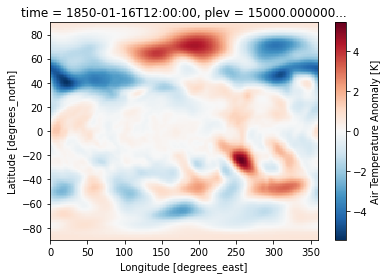

In [10]:
anomaly[0,10,:,:].plot()